# This notebook plots the MCS initiation and mature stage diurnal cycle over a specified region and period

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
%matplotlib inline

In [3]:
# Dictionary for official model names
model_name = {
    'scream': 'SCREAM',
    'mpi': 'ICON',
    'nasa': 'GEOS',
    'nicam': 'NICAM',
    'uk': 'UM',
    'noaa': 'X-SHiELD',
}

# Select a region (Tropics, MC, ITCZ, SPCZ, WP, IO, AFC, AMZ)
region_name = 'Tropics'
# region_name = 'WP'

# Min number of MCS to plot
min_ntracks = 20
# min_ntracks = 9

lifetime_bounds = [2,100]
sdate = '2020-01-25T00'
edate = '2020-03-01T00'


# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

test = ''
# test = '_pf0duration'
rootdir = '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/'
obsdir = f'{rootdir}obs/stats{test}/'
obsfile = f'{obsdir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'

name_map = {
    'obs': 'obs',
    'm1': 'mpi',
    'm2': 'scream',
    'm3': 'nasa',
    'm4': 'nicam',
    'm5': 'noaa',
    'm6': 'uk',
}
m1dir = f'{rootdir}{name_map["m1"]}/stats{test}/'
m2dir = f'{rootdir}{name_map["m2"]}/stats{test}/'
m3dir = f'{rootdir}{name_map["m3"]}/stats{test}/'
m4dir = f'{rootdir}{name_map["m4"]}/stats{test}/'
m5dir = f'{rootdir}{name_map["m5"]}/stats{test}/'
m6dir = f'{rootdir}{name_map["m6"]}/stats{test}/'
m1file = f'{m1dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m2file = f'{m2dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m3file = f'{m3dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m4file = f'{m4dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m5file = f'{m5dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m6file = f'{m6dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures{test}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures/


## Custom functions for track selections

In [4]:
def find_track_in_region(start_basetime, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track initiation location
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_basetime >= pd.to_datetime(sdate)) & (start_basetime <= pd.to_datetime(edate)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds))
    )[0]
    return mcsidx

def get_land_ocean_ds(ds, trackidx, land_frac_thresh, ocean_frac_thresh):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Subset tracks from Dataset
    ds = ds.isel(tracks=trackidx)

    # Calculate lifetime-mean PF land fraction
    init_landfrac = ds['pf_landfrac'].isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds['pf_landfrac'].mean(dim='times')
    # Separate land vs. ocean tracks
    mcsidx_land = np.where(avg_landfrac > land_frac_thresh)[0]
    mcsidx_ocean = np.where(avg_landfrac < ocean_frac_thresh)[0]
    # Subset tracks for land vs. ocean
    ds_l = ds.isel(tracks=mcsidx_land)
    ds_o = ds.isel(tracks=mcsidx_ocean)    
    return (ds_l, ds_o)

def find_merge_split_tracks(ds):
    """
    Find merge/split track indices.
    """
    # non-split tracks
    idx_nsplit = np.isnan(ds.start_split_cloudnumber)
    # non-merge tracks
    idx_nmerge = np.isnan(ds.end_merge_cloudnumber)
    # non-merge and non-split tracks
    idx_nms = np.isnan(ds.start_split_cloudnumber) & np.isnan(ds.end_merge_cloudnumber)
    # merge or split tracks
    idx_ms = ~np.isnan(ds.start_split_cloudnumber) | ~np.isnan(ds.end_merge_cloudnumber)
    # Group outputs to dictionary
    out_dict = {
        'ms': idx_ms,
        'nms': idx_nms,
        'nm': idx_nmerge,
        'ns': idx_nsplit,
    }
    return out_dict

## Functions for diurnal cycle analysis

In [5]:
def utc2lt(UTC, lon):
    """
    A simple function to convert UTC time to local solar time for a given longitude.
    
    Arguments:
       UTC: array-like
           Time in UTC.
       lon: array-like
           Longitude in degrees.
           
    Returns:
       localtime: array-like
           Local solar time.
    """
    
    # Hour per degree longitude 
    hourperdeg = 24./360.
    # Convert to local time
    localtime = UTC + lon * hourperdeg
    
    # Adjust time
    if np.count_nonzero(localtime >= 24) > 0:
        localtime[localtime >= 24] -= 24
    
    if np.count_nonzero(localtime < 0) > 0:
        localtime[localtime < 0] += 24

    return localtime

def harmonic_phase_amplitude(var, nharm, hr1, binsize=1.0):
    """
    Calculates the harmonic phase and amplitude for the requested number
    of harmonics. The phase indicates the location of the peak closest to
    T=0 for each harmonic along the T-axis--it can be on either side of 0.
    
    Arguments:
       var   = array to be analyzed, XT ordering assumed.
       nharm = number of harmonics to calculate
       hr1   = hour of the first time in the time series--used to adj. phase to be 0 at 0 hrs
       binsize = size of the hour bin for calculating phase. default=1.0
       
    Returns:
       amp[nharm] = amplitude of each harmonic
       phs[nharm] = phase of each harmonic, with 0 phase set to hour 0
       pvar[nharm] = percent variance explained
    Created: William.Gustafson@pnnl.gov, 17-Jan-2014
    Last modified: William.Gustafson@pnnl.gov, 22-Jan-2014
    Modified by: Zhe.Feng@pnnl.gov, 10-Jan-2019
    """
    nt = var.shape[-1]
#     w = float(nt) / (2.*np.arccos(-1.))
    w = float(nt) * binsize / (2.*np.arccos(-1.))
    ft = fftpack.fft(var, axis=-1)

    # 0th index returned by fft is the trend, so harmonics start at 1
    ampall = np.abs(ft)[1:] * 2./float(nt)  # need all amplitudes to get total variance
    amp = ampall[0:nharm]
    phs = np.angle(ft)[1:nharm+1]
#     phs = np.angle(ft)[1:nharm+1] * binsize

    totvar = 0.5*np.sum(ampall*ampall)  # total variance
    zeros = np.where(totvar < 1e-12, True, False)  # Need to mask out zero variance values for getting percent values
    totvar_nozeros = np.where(zeros, 1., totvar)
    pvar = np.empty_like(amp)

    for n in range(nharm):
        np1 = n + 1  # adjust by one to get the harmonic number vs. its index
#         phs_offset_max = float(nt)/float(np1)  # max possible phase offset for this harmonic
        phs_offset_max = float(nt) * binsize / float(np1)  # max possible phase offset for this harmonic

        # Have to switch rotation direction of the phase angle to get
        # where first peak occurs. We want it to indicate the angle where
        # the peak occurs. We also do the shift here for the offset due
        # to the first hour not being at 0 (what was sent into this routine).
        phs[n] = phs_offset_max - phs[n] * w / float(np1) + hr1

        # Now, we adjust for a phase that might be a multiple of the given harmonic.
        phs[n] = np.where(phs[n]>phs_offset_max, phs[n]-phs_offset_max, phs[n])
        phs[n] = np.where(phs[n]<0, phs[n] + float(nt)*binsize/float(np1), phs[n])

        # Get percent variance explained by each harmonic.
        pvar[n] = np.where(zeros, 0., 100.*(0.5*amp[n]*amp[n])/totvar_nozeros)
    
    return amp, phs, pvar

In [6]:
# Define region bounds
box_tropics = [0,359,-20,10]
box_mc = [95,150,-20,10]
# box_wp = [155,200,-20,10]
box_wp = [150,210,-30,10]
box_spcz = [150,210,-30,0]
# box_io = [50,90,-15,5]
box_itcz = [130,250,0,15]
box_io = [50,95,-20,10]
box_afc = [10,40,-20,5]
box_amz = [285,320,-20,0]
# Lookup region based on input
bounds_dict = {'Tropics':box_tropics, 'MC':box_mc, 'IO':box_io, 'SPCZ':box_spcz, 'ITCZ':box_itcz, 'WP':box_wp, 'AFC':box_afc, 'AMZ':box_amz}
bounds = bounds_dict[region_name]
print(f'{region_name}: {bounds}')

Tropics: [0, 359, -20, 10]


In [7]:
# Read OBS data
dsobs = xr.open_dataset(obsfile)
time_res_obs = dsobs.attrs['time_resolution_hour']
# dsobs

In [8]:
# Read MODEL data
dsm1 = xr.open_dataset(m1file)
time_res_m1 = dsm1.attrs['time_resolution_hour']
# dsm1

In [9]:
dsm2 = xr.open_dataset(m2file)
time_res_m2 = dsm2.attrs['time_resolution_hour']

In [10]:
dsm3 = xr.open_dataset(m3file)
time_res_m3 = dsm3.attrs['time_resolution_hour']

In [11]:
dsm4 = xr.open_dataset(m4file)
time_res_m4 = dsm4.attrs['time_resolution_hour']

In [12]:
dsm5 = xr.open_dataset(m5file)
time_res_m5 = dsm5.attrs['time_resolution_hour']

In [13]:
dsm6 = xr.open_dataset(m6file)
time_res_m6 = dsm6.attrs['time_resolution_hour']

In [14]:
# lon_bounds = 
lon_bounds = [bounds[0], bounds[1]]
lat_bounds = [bounds[2], bounds[3]]
lon_bounds, lat_bounds, lifetime_bounds

([0, 359], [-20, 10], [2, 100])

In [15]:
# Find tracks by time, region, lifetime
mcsidx_obs = find_track_in_region(dsobs.start_basetime, dsobs.meanlon, dsobs.meanlat, dsobs.track_duration*time_res_obs, lon_bounds, lat_bounds, lifetime_bounds)
print('Number of MCS (OBS): ', len(mcsidx_obs))

# Model m1
mcsidx_m1 = find_track_in_region(dsm1.start_basetime, dsm1.meanlon, dsm1.meanlat, dsm1.track_duration*time_res_m1, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m1"]}): ', len(mcsidx_m1))

# Model m2
mcsidx_m2 = find_track_in_region(dsm2.start_basetime, dsm2.meanlon, dsm2.meanlat, dsm2.track_duration*time_res_m2, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m2"]}): ', len(mcsidx_m2))

# Model m3
mcsidx_m3 = find_track_in_region(dsm3.start_basetime, dsm3.meanlon, dsm3.meanlat, dsm3.track_duration*time_res_m3, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m3"]}): ', len(mcsidx_m3))

# Model m4
mcsidx_m4 = find_track_in_region(dsm4.start_basetime, dsm4.meanlon, dsm4.meanlat, dsm4.track_duration*time_res_m4, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m4"]}): ', len(mcsidx_m4))

# Model m5
mcsidx_m5 = find_track_in_region(dsm5.start_basetime, dsm5.meanlon, dsm5.meanlat, dsm5.track_duration*time_res_m5, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m5"]}): ', len(mcsidx_m5))

# Model m6
mcsidx_m6 = find_track_in_region(dsm6.start_basetime, dsm6.meanlon, dsm6.meanlat, dsm6.track_duration*time_res_m6, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m6"]}): ', len(mcsidx_m6))

Number of MCS (OBS):  1901
Number of MCS (mpi):  589
Number of MCS (scream):  1568
Number of MCS (nasa):  1681
Number of MCS (nicam):  2082
Number of MCS (noaa):  1934
Number of MCS (uk):  1629


## Separate land vs. ocean MCS

In [16]:
# OBS
ds_l_obs, ds_o_obs = get_land_ocean_ds(dsobs, mcsidx_obs, land_frac_thresh, ocean_frac_thresh)
ntracks_l_obs = ds_l_obs.dims['tracks']
ntracks_o_obs = ds_o_obs.dims['tracks']
print(f"Number of land MCS (OBS): {ntracks_l_obs}, Number of ocean MCS (OBS): {ntracks_o_obs}")

# MODEL m1
ds_l_m1, ds_o_m1 = get_land_ocean_ds(dsm1, mcsidx_m1, land_frac_thresh, ocean_frac_thresh)
ntracks_l_m1 = ds_l_m1.dims['tracks']
ntracks_o_m1 = ds_o_m1.dims['tracks']
print(f"Number of land MCS ({name_map['m1']}): {ntracks_l_m1}, Number of ocean MCS ({name_map['m1']}): {ntracks_o_m1}")

# MODEL m2
ds_l_m2, ds_o_m2 = get_land_ocean_ds(dsm2, mcsidx_m2, land_frac_thresh, ocean_frac_thresh)
ntracks_l_m2 = ds_l_m2.dims['tracks']
ntracks_o_m2 = ds_o_m2.dims['tracks']
print(f"Number of land MCS ({name_map['m2']}): {ntracks_l_m2}, Number of ocean MCS ({name_map['m2']}): {ntracks_o_m2}")

# MODEL m3
ds_l_m3, ds_o_m3 = get_land_ocean_ds(dsm3, mcsidx_m3, land_frac_thresh, ocean_frac_thresh)
ntracks_l_m3 = ds_l_m3.dims['tracks']
ntracks_o_m3 = ds_o_m3.dims['tracks']
print(f"Number of land MCS ({name_map['m3']}): {ntracks_l_m3}, Number of ocean MCS ({name_map['m3']}): {ntracks_o_m3}")

# MODEL m4
ds_l_m4, ds_o_m4 = get_land_ocean_ds(dsm4, mcsidx_m4, land_frac_thresh, ocean_frac_thresh)
ntracks_l_m4 = ds_l_m4.dims['tracks']
ntracks_o_m4 = ds_o_m4.dims['tracks']
print(f"Number of land MCS ({name_map['m4']}): {ntracks_l_m4}, Number of ocean MCS ({name_map['m4']}): {ntracks_o_m4}")

# MODEL m5
ds_l_m5, ds_o_m5 = get_land_ocean_ds(dsm5, mcsidx_m5, land_frac_thresh, ocean_frac_thresh)
ntracks_l_m5 = ds_l_m5.dims['tracks']
ntracks_o_m5 = ds_o_m5.dims['tracks']
print(f"Number of land MCS ({name_map['m5']}): {ntracks_l_m5}, Number of ocean MCS ({name_map['m5']}): {ntracks_o_m5}")

# MODEL m6
ds_l_m6, ds_o_m6 = get_land_ocean_ds(dsm6, mcsidx_m6, land_frac_thresh, ocean_frac_thresh)
ntracks_l_m6 = ds_l_m6.dims['tracks']
ntracks_o_m6 = ds_o_m6.dims['tracks']
print(f"Number of land MCS ({name_map['m6']}): {ntracks_l_m6}, Number of ocean MCS ({name_map['m6']}): {ntracks_o_m6}")

Number of land MCS (OBS): 598, Number of ocean MCS (OBS): 981
Number of land MCS (mpi): 259, Number of ocean MCS (mpi): 180
Number of land MCS (scream): 519, Number of ocean MCS (scream): 696
Number of land MCS (nasa): 786, Number of ocean MCS (nasa): 660
Number of land MCS (nicam): 521, Number of ocean MCS (nicam): 1112
Number of land MCS (noaa): 534, Number of ocean MCS (noaa): 1010
Number of land MCS (uk): 592, Number of ocean MCS (uk): 724


## Find merge/split track indices

In [17]:
# OBS
tid_o_obs = find_merge_split_tracks(ds_o_obs)
tid_l_obs = find_merge_split_tracks(ds_l_obs)

# MODEL m1
tid_o_m1 = find_merge_split_tracks(ds_o_m1)
tid_l_m1 = find_merge_split_tracks(ds_l_m1)

# MODEL m2
tid_o_m2 = find_merge_split_tracks(ds_o_m2)
tid_l_m2 = find_merge_split_tracks(ds_l_m2)

# MODEL m3
tid_o_m3 = find_merge_split_tracks(ds_o_m3)
tid_l_m3 = find_merge_split_tracks(ds_l_m3)

# MODEL m4
tid_o_m4 = find_merge_split_tracks(ds_o_m4)
tid_l_m4 = find_merge_split_tracks(ds_l_m4)

# MODEL m5
tid_o_m5 = find_merge_split_tracks(ds_o_m5)
tid_l_m5 = find_merge_split_tracks(ds_l_m5)

# MODEL m6
tid_o_m6 = find_merge_split_tracks(ds_o_m6)
tid_l_m6 = find_merge_split_tracks(ds_l_m6)

## Subset merge/split tracks

In [18]:
# ds_nms_o_obs = ds_o_obs.isel(tracks=tid_o_obs['nms'])
# ds_nms_l_obs = ds_l_obs.isel(tracks=tid_l_obs['nms'])
ds_ns_o_obs = ds_o_obs.isel(tracks=tid_o_obs['ns'])
ds_ns_l_obs = ds_l_obs.isel(tracks=tid_l_obs['ns'])

In [19]:
# ds_nms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['nms'])
# ds_nms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['nms'])
ds_ns_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['ns'])
ds_ns_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['ns'])

In [20]:
# ds_nms_o_m2 = ds_o_m2.isel(tracks=tid_o_m2['nms'])
# ds_nms_l_m2 = ds_l_m2.isel(tracks=tid_l_m2['nms'])
ds_ns_o_m2 = ds_o_m2.isel(tracks=tid_o_m2['ns'])
ds_ns_l_m2 = ds_l_m2.isel(tracks=tid_l_m2['ns'])

In [21]:
# ds_nms_o_m3 = ds_o_m3.isel(tracks=tid_o_m3['nms'])
# ds_nms_l_m3 = ds_l_m3.isel(tracks=tid_l_m3['nms'])
ds_ns_o_m3 = ds_o_m3.isel(tracks=tid_o_m3['ns'])
ds_ns_l_m3 = ds_l_m3.isel(tracks=tid_l_m3['ns'])

In [22]:
# ds_nms_o_m4 = ds_o_m4.isel(tracks=tid_o_m4['nms'])
# ds_nms_l_m4 = ds_l_m4.isel(tracks=tid_l_m4['nms'])
ds_ns_o_m4 = ds_o_m4.isel(tracks=tid_o_m4['ns'])
ds_ns_l_m4 = ds_l_m4.isel(tracks=tid_l_m4['ns'])

In [23]:
# ds_nms_o_m5 = ds_o_m5.isel(tracks=tid_o_m5['nms'])
# ds_nms_l_m5 = ds_l_m5.isel(tracks=tid_l_m5['nms'])
ds_ns_o_m5 = ds_o_m5.isel(tracks=tid_o_m5['ns'])
ds_ns_l_m5 = ds_l_m5.isel(tracks=tid_l_m5['ns'])

In [24]:
# ds_nms_o_m6 = ds_o_m6.isel(tracks=tid_o_m6['nms'])
# ds_nms_l_m6 = ds_l_m6.isel(tracks=tid_l_m6['nms'])
ds_ns_o_m6 = ds_o_m6.isel(tracks=tid_o_m6['ns'])
ds_ns_l_m6 = ds_l_m6.isel(tracks=tid_l_m6['ns'])

In [25]:
# Get number of tracks
ntracks_ns_o_obs = ds_ns_o_obs.dims['tracks']
ntracks_ns_o_m1 = ds_ns_o_m1.dims['tracks']
ntracks_ns_o_m2 = ds_ns_o_m2.dims['tracks']
ntracks_ns_o_m3 = ds_ns_o_m3.dims['tracks']
ntracks_ns_o_m4 = ds_ns_o_m4.dims['tracks']
ntracks_ns_o_m5 = ds_ns_o_m5.dims['tracks']
ntracks_ns_o_m6 = ds_ns_o_m6.dims['tracks']

ntracks_ns_l_obs = ds_ns_l_obs.dims['tracks']
ntracks_ns_l_m1 = ds_ns_l_m1.dims['tracks']
ntracks_ns_l_m2 = ds_ns_l_m2.dims['tracks']
ntracks_ns_l_m3 = ds_ns_l_m3.dims['tracks']
ntracks_ns_l_m4 = ds_ns_l_m4.dims['tracks']
ntracks_ns_l_m5 = ds_ns_l_m5.dims['tracks']
ntracks_ns_l_m6 = ds_ns_l_m6.dims['tracks']

print(f"Number of land MCS (OBS): {ntracks_ns_l_obs}, Number of ocean MCS (OBS): {ntracks_ns_o_obs}")
print(f"Number of land MCS ({name_map['m1']}): {ntracks_ns_l_m6}, Number of ocean MCS ({name_map['m1']}): {ntracks_ns_o_m1}")
print(f"Number of land MCS ({name_map['m2']}): {ntracks_ns_l_m6}, Number of ocean MCS ({name_map['m2']}): {ntracks_ns_o_m2}")
print(f"Number of land MCS ({name_map['m3']}): {ntracks_ns_l_m6}, Number of ocean MCS ({name_map['m3']}): {ntracks_ns_o_m3}")
print(f"Number of land MCS ({name_map['m4']}): {ntracks_ns_l_m6}, Number of ocean MCS ({name_map['m4']}): {ntracks_ns_o_m4}")
print(f"Number of land MCS ({name_map['m5']}): {ntracks_ns_l_m6}, Number of ocean MCS ({name_map['m5']}): {ntracks_ns_o_m5}")
print(f"Number of land MCS ({name_map['m6']}): {ntracks_ns_l_m6}, Number of ocean MCS ({name_map['m6']}): {ntracks_ns_o_m6}")

Number of land MCS (OBS): 400, Number of ocean MCS (OBS): 557
Number of land MCS (mpi): 346, Number of ocean MCS (mpi): 33
Number of land MCS (scream): 346, Number of ocean MCS (scream): 482
Number of land MCS (nasa): 346, Number of ocean MCS (nasa): 415
Number of land MCS (nicam): 346, Number of ocean MCS (nicam): 423
Number of land MCS (noaa): 346, Number of ocean MCS (noaa): 493
Number of land MCS (uk): 346, Number of ocean MCS (uk): 274


In [26]:
def get_mcs_diurnal_hours(ds, binhour):
    """
    Get MCS diurnal hour PDF in local time.
    """
    # Get base time (UTC)
    base_time = ds.base_time.load()
    # Convert base time to fractional hour
    hourUTC = base_time.dt.hour + (base_time.dt.minute / 60)
    # Convert UTC time to local time
    hourLT = utc2lt(hourUTC.data, ds.meanlon.data)
    # Convert to DataArray for convenience
    hourLT = xr.DataArray(hourLT, coords={'tracks':ds.tracks, 'times':ds.times}, dims=('tracks','times'))
    
    binrange = (np.min(binhour), np.max(binhour))
    # MCS initiation hours histogram
    pdf_inithour, bins = np.histogram(hourLT.isel(times=0), bins=binhour, range=binrange, density=True)
    # MCS stage hours histogram
    pdf_mcshour, bins = np.histogram(hourLT.where(ds.pf_mcsstatus == 1), bins=binhour, range=binrange, density=True)
    
    return pdf_inithour, pdf_mcshour

In [27]:
# Set up diurnal hour bins
binhour = np.arange(0, 24.1, 2)
binhour_v = binhour[:-1] + np.diff(binhour)/2

## Use non-split tracks for diurnal cycle

In [28]:
# Land
if ntracks_ns_l_obs > min_ntracks:
    pdf_inithour_l_obs, pdf_mcshour_l_obs = get_mcs_diurnal_hours(ds_ns_l_obs, binhour)
if ntracks_ns_l_m1 > min_ntracks:
    pdf_inithour_l_m1, pdf_mcshour_l_m1 = get_mcs_diurnal_hours(ds_ns_l_m1, binhour)
if ntracks_ns_l_m2 > min_ntracks:
    pdf_inithour_l_m2, pdf_mcshour_l_m2 = get_mcs_diurnal_hours(ds_ns_l_m2, binhour)
if ntracks_ns_l_m3 > min_ntracks:
    pdf_inithour_l_m3, pdf_mcshour_l_m3 = get_mcs_diurnal_hours(ds_ns_l_m3, binhour)
if ntracks_ns_l_m4 > min_ntracks:
    pdf_inithour_l_m4, pdf_mcshour_l_m4 = get_mcs_diurnal_hours(ds_ns_l_m4, binhour)
if ntracks_ns_l_m5 > min_ntracks:
    pdf_inithour_l_m5, pdf_mcshour_l_m5 = get_mcs_diurnal_hours(ds_ns_l_m5, binhour)
if ntracks_ns_l_m6 > min_ntracks:
    pdf_inithour_l_m6, pdf_mcshour_l_m6 = get_mcs_diurnal_hours(ds_ns_l_m6, binhour)

In [29]:
# Ocean
if ntracks_ns_o_obs > min_ntracks:
    pdf_inithour_o_obs, pdf_mcshour_o_obs = get_mcs_diurnal_hours(ds_ns_o_obs, binhour)
if ntracks_ns_o_m1 > min_ntracks:
    pdf_inithour_o_m1, pdf_mcshour_o_m1 = get_mcs_diurnal_hours(ds_ns_o_m1, binhour)
if ntracks_ns_o_m2 > min_ntracks:
    pdf_inithour_o_m2, pdf_mcshour_o_m2 = get_mcs_diurnal_hours(ds_ns_o_m2, binhour)
if ntracks_ns_o_m3 > min_ntracks:
    pdf_inithour_o_m3, pdf_mcshour_o_m3 = get_mcs_diurnal_hours(ds_ns_o_m3, binhour)
if ntracks_ns_o_m4 > min_ntracks:
    pdf_inithour_o_m4, pdf_mcshour_o_m4 = get_mcs_diurnal_hours(ds_ns_o_m4, binhour)
if ntracks_ns_o_m5 > min_ntracks:
    pdf_inithour_o_m5, pdf_mcshour_o_m5 = get_mcs_diurnal_hours(ds_ns_o_m5, binhour)
if ntracks_ns_o_m6 > min_ntracks:
    pdf_inithour_o_m6, pdf_mcshour_o_m6 = get_mcs_diurnal_hours(ds_ns_o_m6, binhour)

In [30]:
# pdf_inithour_l_obs, pdf_mcshour_l_obs = get_mcs_diurnal_hours(ds_nms_l_obs, binhour)
# pdf_inithour_l_m1, pdf_mcshour_l_m1 = get_mcs_diurnal_hours(ds_nms_l_m1, binhour)
# pdf_inithour_l_m2, pdf_mcshour_l_m2 = get_mcs_diurnal_hours(ds_nms_l_m2, binhour)
# pdf_inithour_l_m3, pdf_mcshour_l_m3 = get_mcs_diurnal_hours(ds_nms_l_m3, binhour)
# pdf_inithour_l_m4, pdf_mcshour_l_m4 = get_mcs_diurnal_hours(ds_nms_l_m4, binhour)
# pdf_inithour_l_m5, pdf_mcshour_l_m5 = get_mcs_diurnal_hours(ds_nms_l_m5, binhour)
# pdf_inithour_l_m6, pdf_mcshour_l_m6 = get_mcs_diurnal_hours(ds_nms_l_m6, binhour)

In [31]:
# pdf_inithour_o_obs, pdf_mcshour_o_obs = get_mcs_diurnal_hours(ds_nms_o_obs, binhour)
# pdf_inithour_o_m1, pdf_mcshour_o_m1 = get_mcs_diurnal_hours(ds_nms_o_m1, binhour)
# pdf_inithour_o_m2, pdf_mcshour_o_m2 = get_mcs_diurnal_hours(ds_nms_o_m2, binhour)
# pdf_inithour_o_m3, pdf_mcshour_o_m3 = get_mcs_diurnal_hours(ds_nms_o_m3, binhour)
# pdf_inithour_o_m4, pdf_mcshour_o_m4 = get_mcs_diurnal_hours(ds_nms_o_m4, binhour)
# pdf_inithour_o_m5, pdf_mcshour_o_m5 = get_mcs_diurnal_hours(ds_nms_o_m5, binhour)
# pdf_inithour_o_m6, pdf_mcshour_o_m6 = get_mcs_diurnal_hours(ds_nms_o_m6, binhour)

## Calculate diurnal cycle amplitude and phase

In [32]:
nharm = 8
binsize = 2
# OBS
if ntracks_ns_l_obs > min_ntracks:
    amp_init_l_obs, phs_init_l_obs, pvar_init_l_obs = harmonic_phase_amplitude(pdf_inithour_l_obs, nharm, 0., binsize=binsize)
    amp_mat_l_obs, phs_mat_l_obs, pvar_mat_l_obs = harmonic_phase_amplitude(pdf_mcshour_l_obs, nharm, 0., binsize=binsize)

# MODEL m1
if ntracks_ns_l_m1 > min_ntracks:
    amp_init_l_m1, phs_init_l_m1, pvar_init_l_m1 = harmonic_phase_amplitude(pdf_inithour_l_m1, nharm, 0., binsize=binsize)
    amp_mat_l_m1, phs_mat_l_m1, pvar_mat_l_m1 = harmonic_phase_amplitude(pdf_mcshour_l_m1, nharm, 0., binsize=binsize)

# MODEL m2
if ntracks_ns_l_m2 > min_ntracks:
    amp_init_l_m2, phs_init_l_m2, pvar_init_l_m2 = harmonic_phase_amplitude(pdf_inithour_l_m2, nharm, 0., binsize=binsize)
    amp_mat_l_m2, phs_mat_l_m2, pvar_mat_l_m2 = harmonic_phase_amplitude(pdf_mcshour_l_m2, nharm, 0., binsize=binsize)

# MODEL m3
if ntracks_ns_l_m3 > min_ntracks:
    amp_init_l_m3, phs_init_l_m3, pvar_init_l_m3 = harmonic_phase_amplitude(pdf_inithour_l_m3, nharm, 0., binsize=binsize)
    amp_mat_l_m3, phs_mat_l_m3, pvar_mat_l_m3 = harmonic_phase_amplitude(pdf_mcshour_l_m3, nharm, 0., binsize=binsize)

# MODEL m4
if ntracks_ns_l_m4 > min_ntracks:
    amp_init_l_m4, phs_init_l_m4, pvar_init_l_m4 = harmonic_phase_amplitude(pdf_inithour_l_m4, nharm, 0., binsize=binsize)
    amp_mat_l_m4, phs_mat_l_m4, pvar_mat_l_m4 = harmonic_phase_amplitude(pdf_mcshour_l_m4, nharm, 0., binsize=binsize)

# MODEL m5
if ntracks_ns_l_m5 > min_ntracks:
    amp_init_l_m5, phs_init_l_m5, pvar_init_l_m5 = harmonic_phase_amplitude(pdf_inithour_l_m5, nharm, 0., binsize=binsize)
    amp_mat_l_m5, phs_mat_l_m5, pvar_mat_l_m5 = harmonic_phase_amplitude(pdf_mcshour_l_m5, nharm, 0., binsize=binsize)

# MODEL m6
if ntracks_ns_l_m6 > min_ntracks:
    amp_init_l_m6, phs_init_l_m6, pvar_init_l_m6 = harmonic_phase_amplitude(pdf_inithour_l_m6, nharm, 0., binsize=binsize)
    amp_mat_l_m6, phs_mat_l_m6, pvar_mat_l_m6 = harmonic_phase_amplitude(pdf_mcshour_l_m6, nharm, 0., binsize=binsize)

In [33]:
# OBS
if ntracks_ns_o_obs > min_ntracks:
    amp_init_o_obs, phs_init_o_obs, pvar_init_o_obs = harmonic_phase_amplitude(pdf_inithour_o_obs, nharm, 0., binsize=binsize)
    amp_mat_o_obs, phs_mat_o_obs, pvar_mat_o_obs = harmonic_phase_amplitude(pdf_mcshour_o_obs, nharm, 0., binsize=binsize)

# MODEL m1
if ntracks_ns_o_m1 > min_ntracks:
    amp_init_o_m1, phs_init_o_m1, pvar_init_o_m1 = harmonic_phase_amplitude(pdf_inithour_o_m1, nharm, 0., binsize=binsize)
    amp_mat_o_m1, phs_mat_o_m1, pvar_mat_o_m1 = harmonic_phase_amplitude(pdf_mcshour_o_m1, nharm, 0., binsize=binsize)

# MODEL m2
if ntracks_ns_o_m2 > min_ntracks:
    amp_init_o_m2, phs_init_o_m2, pvar_init_o_m2 = harmonic_phase_amplitude(pdf_inithour_o_m2, nharm, 0., binsize=binsize)
    amp_mat_o_m2, phs_mat_o_m2, pvar_mat_o_m2 = harmonic_phase_amplitude(pdf_mcshour_o_m2, nharm, 0., binsize=binsize)

# MODEL m3
if ntracks_ns_o_m3 > min_ntracks:
    amp_init_o_m3, phs_init_o_m3, pvar_init_o_m3 = harmonic_phase_amplitude(pdf_inithour_o_m3, nharm, 0., binsize=binsize)
    amp_mat_o_m3, phs_mat_o_m3, pvar_mat_o_m3 = harmonic_phase_amplitude(pdf_mcshour_o_m3, nharm, 0., binsize=binsize)

# MODEL m4
if ntracks_ns_o_m4 > min_ntracks:
    amp_init_o_m4, phs_init_o_m4, pvar_init_o_m4 = harmonic_phase_amplitude(pdf_inithour_o_m4, nharm, 0., binsize=binsize)
    amp_mat_o_m4, phs_mat_o_m4, pvar_mat_o_m4 = harmonic_phase_amplitude(pdf_mcshour_o_m4, nharm, 0., binsize=binsize)

# MODEL m5
if ntracks_ns_o_m5 > min_ntracks:
    amp_init_o_m5, phs_init_o_m5, pvar_init_o_m5 = harmonic_phase_amplitude(pdf_inithour_o_m5, nharm, 0., binsize=binsize)
    amp_mat_o_m5, phs_mat_o_m5, pvar_mat_o_m5 = harmonic_phase_amplitude(pdf_mcshour_o_m5, nharm, 0., binsize=binsize)

# MODEL m6
if ntracks_ns_o_m6 > min_ntracks:
    amp_init_o_m6, phs_init_o_m6, pvar_init_o_m6 = harmonic_phase_amplitude(pdf_inithour_o_m6, nharm, 0., binsize=binsize)
    amp_mat_o_m6, phs_mat_o_m6, pvar_mat_o_m6 = harmonic_phase_amplitude(pdf_mcshour_o_m6, nharm, 0., binsize=binsize)

In [34]:
print(f'Number of non-split tracks (land):')
print(f'OBS: {ntracks_ns_l_obs}, '+\
      f'{model_name[name_map["m1"]]}: {ntracks_ns_l_m1}, '+\
      f'{model_name[name_map["m2"]]}: {ntracks_ns_l_m2}, '+\
      f'{model_name[name_map["m3"]]}: {ntracks_ns_l_m3}, '+\
      f'{model_name[name_map["m4"]]}: {ntracks_ns_l_m4}, '+\
      f'{model_name[name_map["m5"]]}: {ntracks_ns_l_m5}, '+\
      f'{model_name[name_map["m6"]]}: {ntracks_ns_l_m6}')

print(f'Number of non-split tracks (ocean):')
print(f'OBS: {ntracks_ns_o_obs}, '+\
      f'{model_name[name_map["m1"]]}: {ntracks_ns_o_m1}, '+\
      f'{model_name[name_map["m2"]]}: {ntracks_ns_o_m2}, '+\
      f'{model_name[name_map["m3"]]}: {ntracks_ns_o_m3}, '+\
      f'{model_name[name_map["m4"]]}: {ntracks_ns_o_m4}, '+\
      f'{model_name[name_map["m5"]]}: {ntracks_ns_o_m5}, '+\
      f'{model_name[name_map["m6"]]}: {ntracks_ns_o_m6}')

Number of non-split tracks (land):
OBS: 400, ICON: 122, SCREAM: 432, GEOS: 574, NICAM: 331, X-SHiELD: 390, UM: 346
Number of non-split tracks (ocean):
OBS: 557, ICON: 33, SCREAM: 482, GEOS: 415, NICAM: 423, X-SHiELD: 493, UM: 274


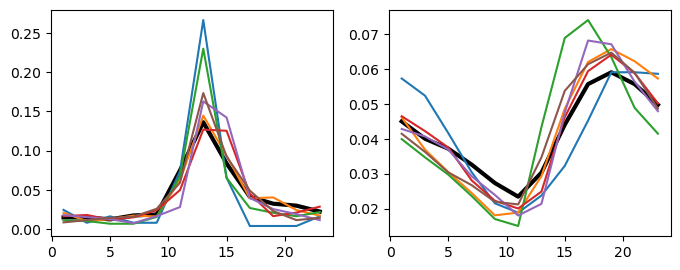

In [35]:
if (ntracks_ns_l_obs > min_ntracks) & \
    (ntracks_ns_l_m1 > min_ntracks) & \
    (ntracks_ns_l_m2 > min_ntracks) & \
    (ntracks_ns_l_m3 > min_ntracks) & \
    (ntracks_ns_l_m4 > min_ntracks) & \
    (ntracks_ns_l_m5 > min_ntracks) & \
    (ntracks_ns_l_m6 > min_ntracks):

    fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=100)
    ax = axes[0]
    ax.plot(binhour_v, pdf_inithour_l_obs, 'k', lw=3)
    ax.plot(binhour_v, pdf_inithour_l_m1)
    ax.plot(binhour_v, pdf_inithour_l_m2)
    ax.plot(binhour_v, pdf_inithour_l_m3)
    ax.plot(binhour_v, pdf_inithour_l_m4)
    ax.plot(binhour_v, pdf_inithour_l_m5)
    ax.plot(binhour_v, pdf_inithour_l_m6)
    ax = axes[1]
    ax.plot(binhour_v, pdf_mcshour_l_obs, 'k', lw=3)
    ax.plot(binhour_v, pdf_mcshour_l_m1)
    ax.plot(binhour_v, pdf_mcshour_l_m2)
    ax.plot(binhour_v, pdf_mcshour_l_m3)
    ax.plot(binhour_v, pdf_mcshour_l_m4)
    ax.plot(binhour_v, pdf_mcshour_l_m5)
    ax.plot(binhour_v, pdf_mcshour_l_m6)

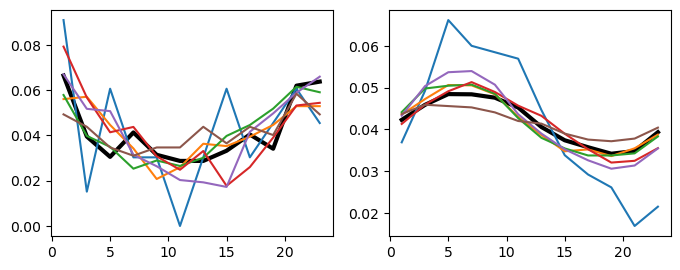

In [36]:
if (ntracks_ns_o_obs > min_ntracks) & \
    (ntracks_ns_o_m1 > min_ntracks) & \
    (ntracks_ns_o_m2 > min_ntracks) & \
    (ntracks_ns_o_m3 > min_ntracks) & \
    (ntracks_ns_o_m4 > min_ntracks) & \
    (ntracks_ns_o_m5 > min_ntracks) & \
    (ntracks_ns_o_m6 > min_ntracks):
    
    fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=100)
    ax = axes[0]
    ax.plot(binhour_v, pdf_inithour_o_obs, 'k', lw=3)
    ax.plot(binhour_v, pdf_inithour_o_m1)
    ax.plot(binhour_v, pdf_inithour_o_m2)
    ax.plot(binhour_v, pdf_inithour_o_m3)
    ax.plot(binhour_v, pdf_inithour_o_m4)
    ax.plot(binhour_v, pdf_inithour_o_m5)
    ax.plot(binhour_v, pdf_inithour_o_m6)
    ax = axes[1]
    ax.plot(binhour_v, pdf_mcshour_o_obs, 'k', lw=3)
    ax.plot(binhour_v, pdf_mcshour_o_m1)
    ax.plot(binhour_v, pdf_mcshour_o_m2)
    ax.plot(binhour_v, pdf_mcshour_o_m3)
    ax.plot(binhour_v, pdf_mcshour_o_m4)
    ax.plot(binhour_v, pdf_mcshour_o_m5)
    ax.plot(binhour_v, pdf_mcshour_o_m6)

### Plot track locations for to double check land/ocean separation

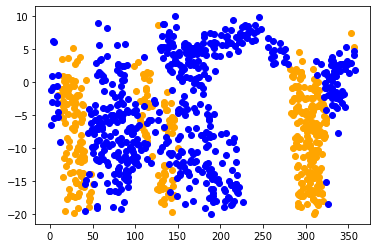

In [37]:
if (ntracks_ns_l_obs > min_ntracks):
    plt.plot(ds_ns_l_obs.meanlon.isel(times=0), ds_ns_l_obs.meanlat.isel(times=0), 'o', color='orange')
if (ntracks_ns_o_obs > min_ntracks):
    plt.plot(ds_ns_o_obs.meanlon.isel(times=0), ds_ns_o_obs.meanlat.isel(times=0), 'o', color='blue')

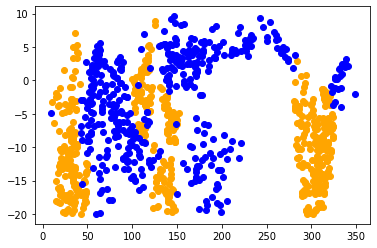

In [38]:
if (ntracks_ns_l_m3 > min_ntracks):
    plt.plot(ds_ns_l_m3.meanlon.isel(times=0), ds_ns_l_m3.meanlat.isel(times=0), 'o', color='orange')
if (ntracks_ns_o_m3 > min_ntracks):
    plt.plot(ds_ns_o_m3.meanlon.isel(times=0), ds_ns_o_m3.meanlat.isel(times=0), 'o', color='blue')

## Calculate fractional difference of diurnal amplitude

In [39]:
if (ntracks_ns_l_obs > min_ntracks) & \
    (ntracks_ns_l_m1 > min_ntracks) & \
    (ntracks_ns_l_m2 > min_ntracks) & \
    (ntracks_ns_l_m3 > min_ntracks) & \
    (ntracks_ns_l_m4 > min_ntracks) & \
    (ntracks_ns_l_m5 > min_ntracks) & \
    (ntracks_ns_l_m6 > min_ntracks):
    
    amp_mat_fracdiff_m1 = 100 * (amp_mat_l_m1[0] - amp_mat_l_obs[0]) / amp_mat_l_obs[0]
    amp_mat_fracdiff_m2 = 100 * (amp_mat_l_m2[0] - amp_mat_l_obs[0]) / amp_mat_l_obs[0]
    amp_mat_fracdiff_m3 = 100 * (amp_mat_l_m3[0] - amp_mat_l_obs[0]) / amp_mat_l_obs[0]
    amp_mat_fracdiff_m4 = 100 * (amp_mat_l_m4[0] - amp_mat_l_obs[0]) / amp_mat_l_obs[0]
    amp_mat_fracdiff_m5 = 100 * (amp_mat_l_m5[0] - amp_mat_l_obs[0]) / amp_mat_l_obs[0]
    amp_mat_fracdiff_m6 = 100 * (amp_mat_l_m6[0] - amp_mat_l_obs[0]) / amp_mat_l_obs[0]
    amp_init_fracdiff_m1 = 100 * (amp_init_l_m1[0] - amp_init_l_obs[0]) / amp_init_l_obs[0]
    amp_init_fracdiff_m2 = 100 * (amp_init_l_m2[0] - amp_init_l_obs[0]) / amp_init_l_obs[0]
    amp_init_fracdiff_m3 = 100 * (amp_init_l_m3[0] - amp_init_l_obs[0]) / amp_init_l_obs[0]
    amp_init_fracdiff_m4 = 100 * (amp_init_l_m4[0] - amp_init_l_obs[0]) / amp_init_l_obs[0]
    amp_init_fracdiff_m5 = 100 * (amp_init_l_m5[0] - amp_init_l_obs[0]) / amp_init_l_obs[0]
    amp_init_fracdiff_m6 = 100 * (amp_init_l_m6[0] - amp_init_l_obs[0]) / amp_init_l_obs[0]
    print(f'Diurnal amplitude difference, MCS initiation (land):')
    print(f'{model_name[name_map["m1"]]}: {amp_init_fracdiff_m1:.0f}%')
    print(f'{model_name[name_map["m2"]]}: {amp_init_fracdiff_m2:.0f}%')
    print(f'{model_name[name_map["m3"]]}: {amp_init_fracdiff_m3:.0f}%')
    print(f'{model_name[name_map["m4"]]}: {amp_init_fracdiff_m4:.0f}%')
    print(f'{model_name[name_map["m5"]]}: {amp_init_fracdiff_m5:.0f}%')
    print(f'{model_name[name_map["m6"]]}: {amp_init_fracdiff_m6:.0f}%')
    print(f'Diurnal amplitude difference, MCS mature (land):')
    print(f'{model_name[name_map["m1"]]}: {amp_mat_fracdiff_m1:.0f}%')
    print(f'{model_name[name_map["m2"]]}: {amp_mat_fracdiff_m2:.0f}%')
    print(f'{model_name[name_map["m3"]]}: {amp_mat_fracdiff_m3:.0f}%')
    print(f'{model_name[name_map["m4"]]}: {amp_mat_fracdiff_m4:.0f}%')
    print(f'{model_name[name_map["m5"]]}: {amp_mat_fracdiff_m5:.0f}%')
    print(f'{model_name[name_map["m6"]]}: {amp_mat_fracdiff_m6:.0f}%')

Diurnal amplitude difference, MCS initiation (land):
ICON: 39%
SCREAM: 5%
GEOS: 31%
NICAM: 3%
X-SHiELD: 23%
UM: 24%
Diurnal amplitude difference, MCS mature (land):
ICON: 39%
SCREAM: 54%
GEOS: 51%
NICAM: 27%
X-SHiELD: 31%
UM: 33%


In [40]:
if (ntracks_ns_o_obs > min_ntracks) & \
    (ntracks_ns_o_m1 > min_ntracks) & \
    (ntracks_ns_o_m2 > min_ntracks) & \
    (ntracks_ns_o_m3 > min_ntracks) & \
    (ntracks_ns_o_m4 > min_ntracks) & \
    (ntracks_ns_o_m5 > min_ntracks) & \
    (ntracks_ns_o_m6 > min_ntracks):
    
    amp_mat_fracdiff_m1 = 100 * (amp_mat_o_m1[0] - amp_mat_o_obs[0]) / amp_mat_o_obs[0]
    amp_mat_fracdiff_m2 = 100 * (amp_mat_o_m2[0] - amp_mat_o_obs[0]) / amp_mat_o_obs[0]
    amp_mat_fracdiff_m3 = 100 * (amp_mat_o_m3[0] - amp_mat_o_obs[0]) / amp_mat_o_obs[0]
    amp_mat_fracdiff_m4 = 100 * (amp_mat_o_m4[0] - amp_mat_o_obs[0]) / amp_mat_o_obs[0]
    amp_mat_fracdiff_m5 = 100 * (amp_mat_o_m5[0] - amp_mat_o_obs[0]) / amp_mat_o_obs[0]
    amp_mat_fracdiff_m6 = 100 * (amp_mat_o_m6[0] - amp_mat_o_obs[0]) / amp_mat_o_obs[0]
    amp_init_fracdiff_m1 = 100 * (amp_init_o_m1[0] - amp_init_o_obs[0]) / amp_init_o_obs[0]
    amp_init_fracdiff_m2 = 100 * (amp_init_o_m2[0] - amp_init_o_obs[0]) / amp_init_o_obs[0]
    amp_init_fracdiff_m3 = 100 * (amp_init_o_m3[0] - amp_init_o_obs[0]) / amp_init_o_obs[0]
    amp_init_fracdiff_m4 = 100 * (amp_init_o_m4[0] - amp_init_o_obs[0]) / amp_init_o_obs[0]
    amp_init_fracdiff_m5 = 100 * (amp_init_o_m5[0] - amp_init_o_obs[0]) / amp_init_o_obs[0]
    amp_init_fracdiff_m6 = 100 * (amp_init_o_m6[0] - amp_init_o_obs[0]) / amp_init_o_obs[0]
    print(f'Diurnal amplitude difference, MCS initiation (ocean):')
    print(f'{model_name[name_map["m1"]]}: {amp_init_fracdiff_m1:.0f}%')
    print(f'{model_name[name_map["m2"]]}: {amp_init_fracdiff_m2:.0f}%')
    print(f'{model_name[name_map["m3"]]}: {amp_init_fracdiff_m3:.0f}%')
    print(f'{model_name[name_map["m4"]]}: {amp_init_fracdiff_m4:.0f}%')
    print(f'{model_name[name_map["m5"]]}: {amp_init_fracdiff_m5:.0f}%')
    print(f'{model_name[name_map["m6"]]}: {amp_init_fracdiff_m6:.0f}%')
    print(f'Diurnal amplitude difference, MCS mature (ocean):')
    print(f'{model_name[name_map["m1"]]}: {amp_mat_fracdiff_m1:.0f}%')
    print(f'{model_name[name_map["m2"]]}: {amp_mat_fracdiff_m2:.0f}%')
    print(f'{model_name[name_map["m3"]]}: {amp_mat_fracdiff_m3:.0f}%')
    print(f'{model_name[name_map["m4"]]}: {amp_mat_fracdiff_m4:.0f}%')
    print(f'{model_name[name_map["m5"]]}: {amp_mat_fracdiff_m5:.0f}%')
    print(f'{model_name[name_map["m6"]]}: {amp_mat_fracdiff_m6:.0f}%')

Diurnal amplitude difference, MCS initiation (ocean):
ICON: 16%
SCREAM: -6%
GEOS: 11%
NICAM: 33%
X-SHiELD: 54%
UM: -45%
Diurnal amplitude difference, MCS mature (ocean):
ICON: 198%
SCREAM: 18%
GEOS: 27%
NICAM: 25%
X-SHiELD: 62%
UM: -41%


## Plot ocean & land in the same plot

In [41]:
def plot_diurnal_2x2(data_arr, binhour_v, titles, xlabels, ylabels, xticks, legends, legend_loc, legend_ncol,
                     map_extent, lonbox, latbox, inset_param, figname, inset_flag=None):

    mpl.rcParams['font.size'] = 14
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=[16,8], dpi=100)
    gs = gridspec.GridSpec(2,2, height_ratios=[1,1], width_ratios=[1,1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.15, hspace=0.3)
    
    lw = 2
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'blue',
        'm6': 'purple',
    }

    for col in range(0,2):
        for row in range(0,2):
            ax = plt.subplot(gs[row,col])
            ax.plot(binhour_v, data_arr[row][col]['obs'], color=lcolors['obs'], lw=lw*3, label=legends[row][col]['obs'])
            ax.plot(binhour_v, data_arr[row][col]['m1'], color=lcolors['m1'], lw=lw, label=legends[row][col]['m1'])
            ax.plot(binhour_v, data_arr[row][col]['m2'], color=lcolors['m2'], lw=lw, label=legends[row][col]['m2'])
            ax.plot(binhour_v, data_arr[row][col]['m3'], color=lcolors['m3'], lw=lw, label=legends[row][col]['m3'])
            ax.plot(binhour_v, data_arr[row][col]['m4'], color=lcolors['m4'], lw=lw, label=legends[row][col]['m4'])
            ax.plot(binhour_v, data_arr[row][col]['m5'], color=lcolors['m5'], lw=lw, label=legends[row][col]['m5'])
            ax.plot(binhour_v, data_arr[row][col]['m6'], color=lcolors['m6'], lw=lw, label=legends[row][col]['m6'])
            ax.grid(which='major', ls='--')
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_xticks(xticks)
            ax.set_title(titles[row][col], loc='left')
            ax.legend(fontsize=9, loc=legend_loc[row][col], ncol=legend_ncol[row][col])

            # Plot inset map
            if (inset_flag[row][col] == True):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param[row][col]['width'], height=inset_param[row][col]['height'], loc=inset_param[row][col]['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param[row][col]['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Plot a box region in the inset
                box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

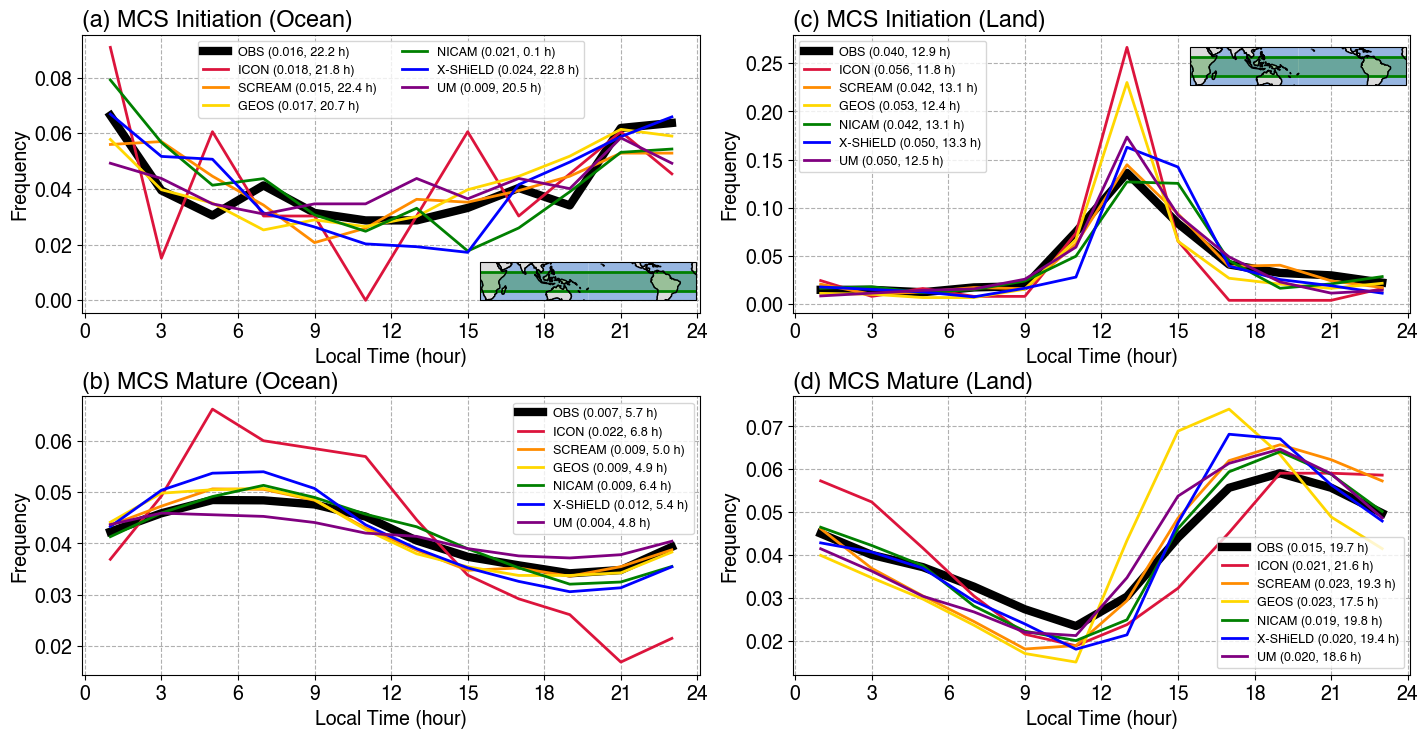

In [42]:
if (ntracks_ns_o_obs > min_ntracks) & \
    (ntracks_ns_o_m1 > min_ntracks) & \
    (ntracks_ns_o_m2 > min_ntracks) & \
    (ntracks_ns_o_m3 > min_ntracks) & \
    (ntracks_ns_o_m4 > min_ntracks) & \
    (ntracks_ns_o_m5 > min_ntracks) & \
    (ntracks_ns_o_m6 > min_ntracks) & \
    (ntracks_ns_l_obs > min_ntracks) & \
    (ntracks_ns_l_m1 > min_ntracks) & \
    (ntracks_ns_l_m2 > min_ntracks) & \
    (ntracks_ns_l_m3 > min_ntracks) & \
    (ntracks_ns_l_m4 > min_ntracks) & \
    (ntracks_ns_l_m5 > min_ntracks) & \
    (ntracks_ns_l_m6 > min_ntracks):

    init_o_dict = {
        'obs': pdf_inithour_o_obs,
        'm1': pdf_inithour_o_m1,
        'm2': pdf_inithour_o_m2,
        'm3': pdf_inithour_o_m3,
        'm4': pdf_inithour_o_m4,
        'm5': pdf_inithour_o_m5,
        'm6': pdf_inithour_o_m6,
    }
    mat_o_dict = {
        'obs': pdf_mcshour_o_obs,
        'm1': pdf_mcshour_o_m1,
        'm2': pdf_mcshour_o_m2,
        'm3': pdf_mcshour_o_m3,
        'm4': pdf_mcshour_o_m4,
        'm5': pdf_mcshour_o_m5,
        'm6': pdf_mcshour_o_m6,
    }
    init_l_dict = {
        'obs': pdf_inithour_l_obs,
        'm1': pdf_inithour_l_m1,
        'm2': pdf_inithour_l_m2,
        'm3': pdf_inithour_l_m3,
        'm4': pdf_inithour_l_m4,
        'm5': pdf_inithour_l_m5,
        'm6': pdf_inithour_l_m6,
    }
    mat_l_dict = {
        'obs': pdf_mcshour_l_obs,
        'm1': pdf_mcshour_l_m1,
        'm2': pdf_mcshour_l_m2,
        'm3': pdf_mcshour_l_m3,
        'm4': pdf_mcshour_l_m4,
        'm5': pdf_mcshour_l_m5,
        'm6': pdf_mcshour_l_m6,
    }

    init_legend_o_dict = {
        'obs': f'OBS ({amp_init_o_obs[0]:.03f}, {phs_init_o_obs[0]:2.1f} h)', 
        'm1': f'{model_name[name_map["m1"]]} ({amp_init_o_m1[0]:.03f}, {phs_init_o_m1[0]:2.1f} h)',
        'm2': f'{model_name[name_map["m2"]]} ({amp_init_o_m2[0]:.03f}, {phs_init_o_m2[0]:2.1f} h)',
        'm3': f'{model_name[name_map["m3"]]} ({amp_init_o_m3[0]:.03f}, {phs_init_o_m3[0]:2.1f} h)', 
        'm4': f'{model_name[name_map["m4"]]} ({amp_init_o_m4[0]:.03f}, {phs_init_o_m4[0]:2.1f} h)',
        'm5': f'{model_name[name_map["m5"]]} ({amp_init_o_m5[0]:.03f}, {phs_init_o_m5[0]:2.1f} h)',
        'm6': f'{model_name[name_map["m6"]]} ({amp_init_o_m6[0]:.03f}, {phs_init_o_m6[0]:2.1f} h)', 
    }
    mat_legend_o_dict = {
        'obs': f'OBS ({amp_mat_o_obs[0]:.03f}, {phs_mat_o_obs[0]:2.1f} h)',
        'm1': f'{model_name[name_map["m1"]]} ({amp_mat_o_m1[0]:.03f}, {phs_mat_o_m1[0]:2.1f} h)',
        'm2': f'{model_name[name_map["m2"]]} ({amp_mat_o_m2[0]:.03f}, {phs_mat_o_m2[0]:2.1f} h)',
        'm3': f'{model_name[name_map["m3"]]} ({amp_mat_o_m3[0]:.03f}, {phs_mat_o_m3[0]:2.1f} h)',
        'm4': f'{model_name[name_map["m4"]]} ({amp_mat_o_m4[0]:.03f}, {phs_mat_o_m4[0]:2.1f} h)',
        'm5': f'{model_name[name_map["m5"]]} ({amp_mat_o_m5[0]:.03f}, {phs_mat_o_m5[0]:2.1f} h)',
        'm6': f'{model_name[name_map["m6"]]} ({amp_mat_o_m6[0]:.03f}, {phs_mat_o_m6[0]:2.1f} h)',
    }
    init_legend_l_dict = {
        'obs': f'OBS ({amp_init_l_obs[0]:.03f}, {phs_init_l_obs[0]:2.1f} h)', 
        'm1': f'{model_name[name_map["m1"]]} ({amp_init_l_m1[0]:.03f}, {phs_init_l_m1[0]:2.1f} h)',
        'm2': f'{model_name[name_map["m2"]]} ({amp_init_l_m2[0]:.03f}, {phs_init_l_m2[0]:2.1f} h)',
        'm3': f'{model_name[name_map["m3"]]} ({amp_init_l_m3[0]:.03f}, {phs_init_l_m3[0]:2.1f} h)', 
        'm4': f'{model_name[name_map["m4"]]} ({amp_init_l_m4[0]:.03f}, {phs_init_l_m4[0]:2.1f} h)',
        'm5': f'{model_name[name_map["m5"]]} ({amp_init_l_m5[0]:.03f}, {phs_init_l_m5[0]:2.1f} h)',
        'm6': f'{model_name[name_map["m6"]]} ({amp_init_l_m6[0]:.03f}, {phs_init_l_m6[0]:2.1f} h)', 
    }
    mat_legend_l_dict = {
        'obs': f'OBS ({amp_mat_l_obs[0]:.03f}, {phs_mat_l_obs[0]:2.1f} h)',
        'm1': f'{model_name[name_map["m1"]]} ({amp_mat_l_m1[0]:.03f}, {phs_mat_l_m1[0]:2.1f} h)',
        'm2': f'{model_name[name_map["m2"]]} ({amp_mat_l_m2[0]:.03f}, {phs_mat_l_m2[0]:2.1f} h)',
        'm3': f'{model_name[name_map["m3"]]} ({amp_mat_l_m3[0]:.03f}, {phs_mat_l_m3[0]:2.1f} h)',
        'm4': f'{model_name[name_map["m4"]]} ({amp_mat_l_m4[0]:.03f}, {phs_mat_l_m4[0]:2.1f} h)',
        'm5': f'{model_name[name_map["m5"]]} ({amp_mat_l_m5[0]:.03f}, {phs_mat_l_m5[0]:2.1f} h)',
        'm6': f'{model_name[name_map["m6"]]} ({amp_mat_l_m6[0]:.03f}, {phs_mat_l_m6[0]:2.1f} h)',
    }
    # Data array [row][col]
    data_arr = [
        [init_o_dict, init_l_dict],
        [mat_o_dict, mat_l_dict],
    ]
    legends = [
        [init_legend_o_dict, init_legend_l_dict],
        [mat_legend_o_dict, mat_legend_l_dict],
    ]
    titles = [
        ['(a) MCS Initiation (Ocean)', '(c) MCS Initiation (Land)'],
        ['(b) MCS Mature (Ocean)', '(d) MCS Mature (Land)'],
    ]
    xlabels = [['Local Time (hour)','Local Time (hour)'],['Local Time (hour)','Local Time (hour)']]
    ylabels = [['Frequency', 'Frequency'],['Frequency', 'Frequency']]
    xticks = np.arange(0,25,3)

    legend_loc = [['upper center','upper left'],['upper right','lower right']]
    legend_ncol = [[2,1],[1,1]]
    map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-15,bounds[3]+15]
    if (bounds[0] > 180) & (bounds[1] > 180):
        lonbox = ((np.array([bounds[0], bounds[1]]) - 180) % 360) - 180
    else:
        lonbox = np.array([bounds[0], bounds[1]])
    latbox = [bounds[2], bounds[3]]
    inset_param = [
        [{'width':'35%', 'height':'20%', 'loc':'lower right', 'borderpad':0.2}, 
         {'width':'35%', 'height':'20%', 'loc':'upper right', 'borderpad':0.2}],
        [{'width':'35%', 'height':'20%', 'loc':'lower left', 'borderpad':0.2}, 
         {'width':'35%', 'height':'20%', 'loc':'upper left', 'borderpad':0.2}],
    ]
    inset_flag = [[True, True], [False, False]]
    figname = f'{figdir}mcs_initiation_mature_time_diurnal_cycle_ocean_land_{region_name}.png'
    fig = plot_diurnal_2x2(data_arr, binhour_v, titles, xlabels, ylabels, xticks, legends, legend_loc, legend_ncol,
                           map_extent, lonbox, latbox, inset_param, figname, inset_flag=inset_flag)

In [43]:
figdir

'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures/'

## Plot ocean vs. land separately

In [43]:
def plot_2diurnal(data_obs, data_m1, data_m2, data_m3, data_m4, data_m5, data_m6,
                  binhour_v, titles, xlabels, ylabels, xticks, legend_loc, legend_ncol,
                  legendobs, legend_m1, legend_m2, legend_m3, legend_m4, legend_m5, legend_m6,
                  map_extent, lonbox, latbox, inset_param, figname):

    mpl.rcParams['font.size'] = 14
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=[8,8], dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.2, hspace=0.25)
    
    lw = 2
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'blue',
        'm6': 'purple',
    }

    for row in range(0,2):
        ax = plt.subplot(gs[row])
        ax.plot(binhour_v, data_obs[row], color=lcolors['obs'], lw=lw*3, label=legendobs[row])
        ax.plot(binhour_v, data_m1[row], color=lcolors['m1'], lw=lw, label=legend_m1[row])
        ax.plot(binhour_v, data_m2[row], color=lcolors['m2'], lw=lw, label=legend_m2[row])
        ax.plot(binhour_v, data_m3[row], color=lcolors['m3'], lw=lw, label=legend_m3[row])
        ax.plot(binhour_v, data_m4[row], color=lcolors['m4'], lw=lw, label=legend_m4[row])
        ax.plot(binhour_v, data_m5[row], color=lcolors['m5'], lw=lw, label=legend_m5[row])
        ax.plot(binhour_v, data_m6[row], color=lcolors['m6'], lw=lw, label=legend_m6[row])
        ax.grid(which='major', ls='--')
        ax.set_xlabel(xlabels[row])
        ax.set_ylabel(ylabels[row])
        ax.set_xticks(xticks)
        ax.set_title(titles[row], loc='left')
        ax.legend(fontsize=9, loc=legend_loc[row], ncol=legend_ncol[row])

        # Plot inset map
        resolution = '110m'
        land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
        ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
        proj = ccrs.PlateCarree(central_longitude=180)
        box_proj = ccrs.PlateCarree(central_longitude=0)
        sub_ax = inset_axes(ax, width=inset_param[row]['width'], height=inset_param[row]['height'], loc=inset_param[row]['loc'],
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param[row]['borderpad'], 
                            axes_kwargs=dict(map_projection=proj))
        sub_ax.set_extent(map_extent, box_proj)
        # Add land, coastlines, borders to inset
        sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
        sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
        sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
        # Plot a box region in the inset
        box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
        sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
        sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

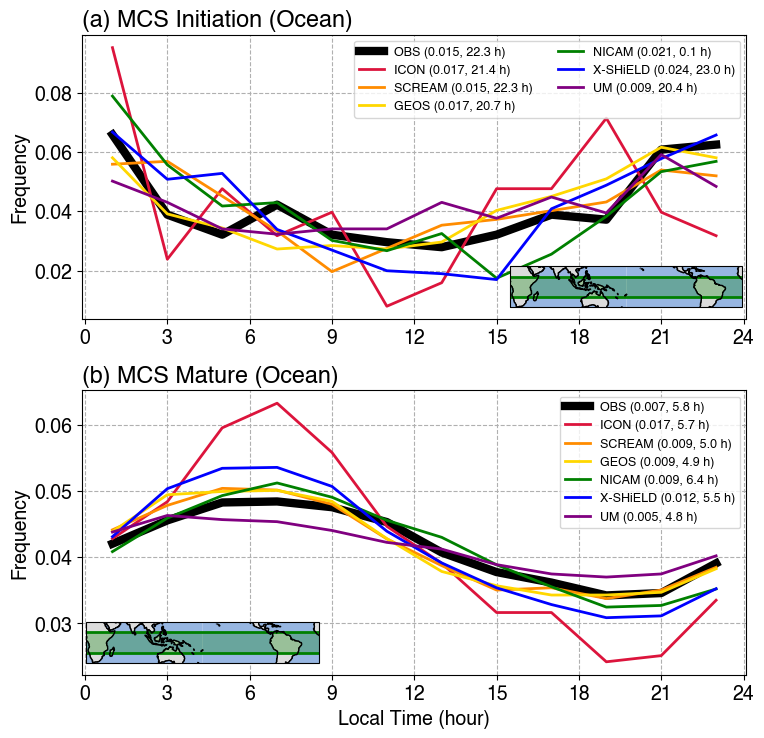

In [44]:
if (ntracks_ns_o_obs > min_ntracks) & \
    (ntracks_ns_o_m1 > min_ntracks) & \
    (ntracks_ns_o_m2 > min_ntracks) & \
    (ntracks_ns_o_m3 > min_ntracks) & \
    (ntracks_ns_o_m4 > min_ntracks) & \
    (ntracks_ns_o_m5 > min_ntracks) & \
    (ntracks_ns_o_m6 > min_ntracks):

    # Ocean
    data_obs = [pdf_inithour_o_obs, pdf_mcshour_o_obs]
    data_m1 = [pdf_inithour_o_m1, pdf_mcshour_o_m1]
    data_m2 = [pdf_inithour_o_m2, pdf_mcshour_o_m2]
    data_m3 = [pdf_inithour_o_m3, pdf_mcshour_o_m3]
    data_m4 = [pdf_inithour_o_m4, pdf_mcshour_o_m4]
    data_m5 = [pdf_inithour_o_m5, pdf_mcshour_o_m5]
    data_m6 = [pdf_inithour_o_m6, pdf_mcshour_o_m6]
    titles = ['(a) MCS Initiation (Ocean)', '(b) MCS Mature (Ocean)']
    xlabels = ['','Local Time (hour)']
    ylabels = ['Frequency', 'Frequency']
    xticks = np.arange(0,25,3)
    legendobs = [f'OBS ({amp_init_o_obs[0]:.03f}, {phs_init_o_obs[0]:2.1f} h)', 
                 f'OBS ({amp_mat_o_obs[0]:.03f}, {phs_mat_o_obs[0]:2.1f} h)']
    legend_m1 = [f'{model_name[name_map["m1"]]} ({amp_init_o_m1[0]:.03f}, {phs_init_o_m1[0]:2.1f} h)', 
                  f'{model_name[name_map["m1"]]} ({amp_mat_o_m1[0]:.03f}, {phs_mat_o_m1[0]:2.1f} h)']
    legend_m2 = [f'{model_name[name_map["m2"]]} ({amp_init_o_m2[0]:.03f}, {phs_init_o_m2[0]:2.1f} h)', 
                  f'{model_name[name_map["m2"]]} ({amp_mat_o_m2[0]:.03f}, {phs_mat_o_m2[0]:2.1f} h)']
    legend_m3 = [f'{model_name[name_map["m3"]]} ({amp_init_o_m3[0]:.03f}, {phs_init_o_m3[0]:2.1f} h)', 
                  f'{model_name[name_map["m3"]]} ({amp_mat_o_m3[0]:.03f}, {phs_mat_o_m3[0]:2.1f} h)']
    legend_m4 = [f'{model_name[name_map["m4"]]} ({amp_init_o_m4[0]:.03f}, {phs_init_o_m4[0]:2.1f} h)', 
                  f'{model_name[name_map["m4"]]} ({amp_mat_o_m4[0]:.03f}, {phs_mat_o_m4[0]:2.1f} h)']
    legend_m5 = [f'{model_name[name_map["m5"]]} ({amp_init_o_m5[0]:.03f}, {phs_init_o_m5[0]:2.1f} h)', 
                  f'{model_name[name_map["m5"]]} ({amp_mat_o_m5[0]:.03f}, {phs_mat_o_m5[0]:2.1f} h)']
    legend_m6 = [f'{model_name[name_map["m6"]]} ({amp_init_o_m6[0]:.03f}, {phs_init_o_m6[0]:2.1f} h)', 
                  f'{model_name[name_map["m6"]]} ({amp_mat_o_m6[0]:.03f}, {phs_mat_o_m6[0]:2.1f} h)']
    legend_loc = ['best', 'best']
    legend_ncol = [2,1]
    map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-15,bounds[3]+15]
    if (bounds[0] > 180) & (bounds[1] > 180):
        lonbox = ((np.array([bounds[0], bounds[1]]) - 180) % 360) - 180
    else:
        lonbox = np.array([bounds[0], bounds[1]])
    latbox = [bounds[2], bounds[3]]
    inset_param = [{'width':'35%', 'height':'20%', 'loc':'lower right', 'borderpad':0.2}, 
                   {'width':'35%', 'height':'20%', 'loc':'lower left', 'borderpad':0.2}]
    figname = f'{figdir}mcs_initiation_mature_time_diurnal_cycle_ocean_{region_name}.png'
    fig = plot_2diurnal(data_obs, data_m1, data_m2, data_m3, data_m4, data_m5, data_m6,
                        binhour_v, titles, xlabels, ylabels, xticks, legend_loc, legend_ncol,
                        legendobs, legend_m1, legend_m2, legend_m3, legend_m4, legend_m5, legend_m6,
                        map_extent, lonbox, latbox, inset_param, figname)

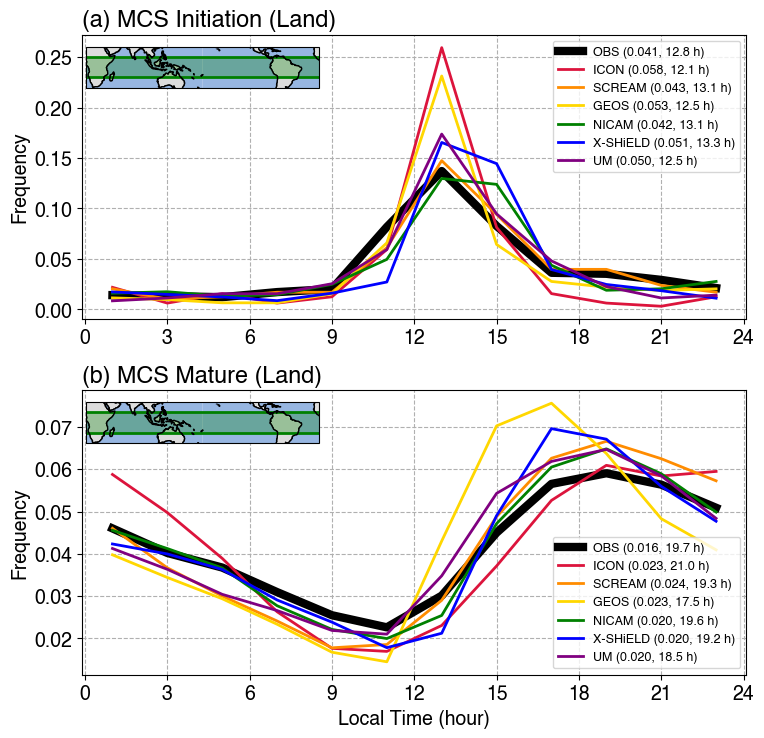

In [45]:
if (ntracks_ns_l_obs > min_ntracks) & \
    (ntracks_ns_l_m1 > min_ntracks) & \
    (ntracks_ns_l_m2 > min_ntracks) & \
    (ntracks_ns_l_m3 > min_ntracks) & \
    (ntracks_ns_l_m4 > min_ntracks) & \
    (ntracks_ns_l_m5 > min_ntracks) & \
    (ntracks_ns_l_m6 > min_ntracks):

    # Land
    data_obs = [pdf_inithour_l_obs, pdf_mcshour_l_obs]
    data_m1 = [pdf_inithour_l_m1, pdf_mcshour_l_m1]
    data_m2 = [pdf_inithour_l_m2, pdf_mcshour_l_m2]
    data_m3 = [pdf_inithour_l_m3, pdf_mcshour_l_m3]
    data_m4 = [pdf_inithour_l_m4, pdf_mcshour_l_m4]
    data_m5 = [pdf_inithour_l_m5, pdf_mcshour_l_m5]
    data_m6 = [pdf_inithour_l_m6, pdf_mcshour_l_m6]
    titles = ['(a) MCS Initiation (Land)', '(b) MCS Mature (Land)']
    xlabels = ['','Local Time (hour)']
    ylabels = ['Frequency', 'Frequency']
    xticks = np.arange(0,25,3)
    legendobs = [f'OBS ({amp_init_l_obs[0]:.03f}, {phs_init_l_obs[0]:2.1f} h)', 
                 f'OBS ({amp_mat_l_obs[0]:.03f}, {phs_mat_l_obs[0]:2.1f} h)']
    legend_m1 = [f'{model_name[name_map["m1"]]} ({amp_init_l_m1[0]:.03f}, {phs_init_l_m1[0]:2.1f} h)', 
                  f'{model_name[name_map["m1"]]} ({amp_mat_l_m1[0]:.03f}, {phs_mat_l_m1[0]:2.1f} h)']
    legend_m2 = [f'{model_name[name_map["m2"]]} ({amp_init_l_m2[0]:.03f}, {phs_init_l_m2[0]:2.1f} h)', 
                  f'{model_name[name_map["m2"]]} ({amp_mat_l_m2[0]:.03f}, {phs_mat_l_m2[0]:2.1f} h)']
    legend_m3 = [f'{model_name[name_map["m3"]]} ({amp_init_l_m3[0]:.03f}, {phs_init_l_m3[0]:2.1f} h)', 
                  f'{model_name[name_map["m3"]]} ({amp_mat_l_m3[0]:.03f}, {phs_mat_l_m3[0]:2.1f} h)']
    legend_m4 = [f'{model_name[name_map["m4"]]} ({amp_init_l_m4[0]:.03f}, {phs_init_l_m4[0]:2.1f} h)', 
                  f'{model_name[name_map["m4"]]} ({amp_mat_l_m4[0]:.03f}, {phs_mat_l_m4[0]:2.1f} h)']
    legend_m5 = [f'{model_name[name_map["m5"]]} ({amp_init_l_m5[0]:.03f}, {phs_init_l_m5[0]:2.1f} h)', 
                  f'{model_name[name_map["m5"]]} ({amp_mat_l_m5[0]:.03f}, {phs_mat_l_m5[0]:2.1f} h)']
    legend_m6 = [f'{model_name[name_map["m6"]]} ({amp_init_l_m6[0]:.03f}, {phs_init_l_m6[0]:2.1f} h)', 
                  f'{model_name[name_map["m6"]]} ({amp_mat_l_m6[0]:.03f}, {phs_mat_l_m6[0]:2.1f} h)']
    legend_loc = ['best', 'best']
    legend_ncol = [1,1]
    map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-15,bounds[3]+15]
    if (bounds[0] > 180) & (bounds[1] > 180):
        lonbox = ((np.array([bounds[0], bounds[1]]) - 180) % 360) - 180
    else:
        lonbox = np.array([bounds[0], bounds[1]])
    latbox = [bounds[2], bounds[3]]
    inset_param = [{'width':'35%', 'height':'20%', 'loc':'upper left', 'borderpad':0.2}, 
                   {'width':'35%', 'height':'20%', 'loc':'upper left', 'borderpad':0.2}]
    figname = f'{figdir}mcs_initiation_mature_time_diurnal_cycle_land_{region_name}.png'
    fig = plot_2diurnal(data_obs, data_m1, data_m2, data_m3, data_m4, data_m5, data_m6,
                        binhour_v, titles, xlabels, ylabels, xticks, legend_loc, legend_ncol,
                        legendobs, legend_m1, legend_m2, legend_m3, legend_m4, legend_m5, legend_m6,
                        map_extent, lonbox, latbox, inset_param, figname)